In [1]:
import warnings
warnings.filterwarnings('ignore')


--- Real Data for QAOA ---
Top 3 Expected Returns: [0.4624017  0.63289659 0.50140743]
Covariance Matrix Shape: (10, 10)


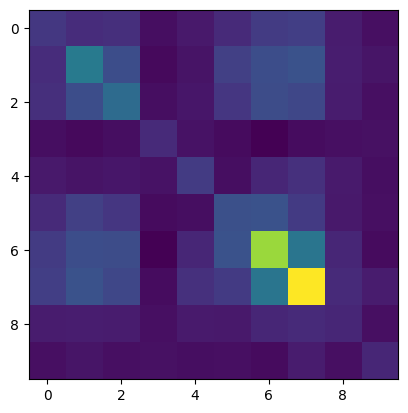

In [2]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ============================
# STEP 1: MARKET DATA
# ============================

tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT"]

data = yf.download(tickers, start="2023-01-01", end="2024-01-01", progress=False)
data = data["Close"]

returns = data.pct_change().dropna()

mu = returns.mean() * 252
sigma = returns.cov() * 252

mu = mu.to_numpy()
sigma = sigma.to_numpy()

print("\n--- Real Data for QAOA ---")
print("Top 3 Expected Returns:", mu[:3])
print("Covariance Matrix Shape:", sigma.shape)


# Plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [3]:

# ============================
# STEP 2: BUILD QP MODEL
# ============================
from qiskit_optimization import QuadraticProgram


budget = 5
risk_factor = 0.5
num_assets = len(tickers)
penalty=10

qp = QuadraticProgram()

for i in range(num_assets):
    qp.binary_var(name=tickers[i])

qp.minimize(
    linear = -mu,
    quadratic = risk_factor * sigma
)

qp.linear_constraint(
    linear = {tickers[i]: 1 for i in range(num_assets)},
    sense  = "==",
    rhs    = budget,
    name   = "budget_constraint"
)



<LinearConstraint: AAPL + AMZN + GOOGL + JNJ + JPM + MSFT + NVDA + TS... == 5 'budget_constraint'>

In [4]:

# ============================
# STEP 3: QUBO CONVERSION
# ============================
from qiskit_optimization.converters import QuadraticProgramToQubo

converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)



--- 4. QAOA RESULTS ---
Optimal binary solution: [1. 1. 0. 0. 0. 1. 1. 1. 0. 0.]
Selected portfolio: ['AAPL', 'GOOGL', 'NVDA', 'JPM', 'V']


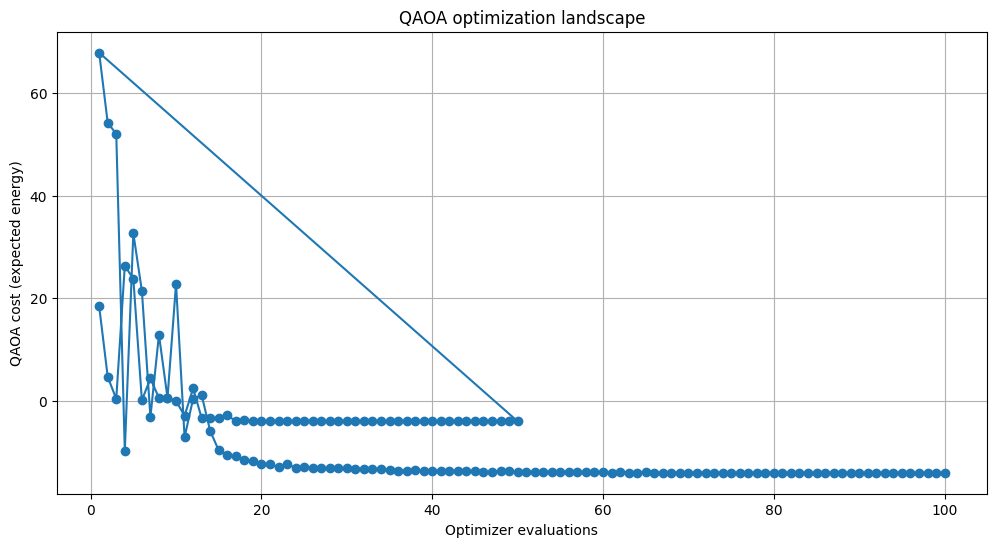

In [5]:
# ============================
# STEP 4: QAOA SOLVER
# ============================

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp

# Convert QUBO -> Ising Hamiltonian
op, offset = qubo.to_ising()

try:
    op = SparsePauliOp(op.paulis, op.coeffs.real)
except:
    mat = op.to_matrix().real
    op = SparsePauliOp.from_operator(mat)

# Track optimization landscape
opt_history = []
def qaoa_callback(eval_count, params, mean, std):
    opt_history.append((eval_count, mean))

# QAOA solver
sampler = Sampler()

qaoa = QAOA(
    sampler=sampler,
    optimizer=COBYLA(maxiter=100),
    reps=1,
    callback=qaoa_callback
)

# Compute eigenvalue with QAOA
eigen_result = qaoa.compute_minimum_eigenvalue(op)
solver = MinimumEigenOptimizer(qaoa)

result = solver.solve(qubo)

print("\n--- 4. QAOA RESULTS ---")
selection = result.x
print("Optimal binary solution:", selection)

selected_tickers = [tickers[i] for i, x in enumerate(selection) if x == 1]
print("Selected portfolio:", selected_tickers)

# === Plot optimization landscape ===
steps = [s for s, v in opt_history]
values = [v for s, v in opt_history]

plt.figure(figsize=(12, 6))

plt.plot(steps, values, marker="o")
plt.xlabel("Optimizer evaluations")
plt.ylabel("QAOA cost (expected energy)")
plt.title("QAOA optimization landscape")
plt.grid(True)
plt.show()


In [6]:


# ============================
# STEP 5: RESULTS
# ============================

# Metrics
opt_return = np.dot(mu, selection)
opt_risk   = np.sqrt(selection.T @ sigma @ selection)
sharpe = opt_return / opt_risk if opt_risk > 0 else 0

print(f"Expected Annual Return: {opt_return:.2%}")
print(f"Annual Volatility (Risk): {opt_risk:.2%}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print("\n==============================")
print(" Quantum Portfolio Completed ")


Expected Annual Return: 394.45%
Annual Volatility (Risk): 133.67%
Sharpe Ratio: 2.9509

 Quantum Portfolio Completed 
